In [7]:
import agentpy as ap
import numpy as np
from numpy.random import default_rng
import statistics
import logging
from itertools import combinations
logging.basicConfig(level=logging.INFO)

In [2]:
class MyAgent(ap.Agent):


    def setup(self):
        self.actual_stocks_owned = 1
        self.utility = 0
        self.cash = self.model.p.initial_cash
        self.wealth = self.cash + self.actual_stocks_owned * self.model.prices[-1]
        self.expectation_p_d = 0
        self.assets_demanded = 0
        self.technical_bits_set = 0
        self.predictors = self.predictors_initialization()
        key = self.model.nprandom.integers(1, 101)
        self.predictor_used = self.predictors.get(key) # first predictor used instantiation
        self.predictor_key_used = key
        self.expectation(self.model.prices[-1])
        self.demand(self.model.prices[-1])
        self.mutation_counter = 0
        self.avg_predictors_variance = sum([value[-1] for value in self.predictors.values()]) / self.model.p.M
        self.avg_predictors_error = sum([value[-3] for value in self.predictors.values()]) / self.model.p.M


    def predictors_initialization(self) -> dict:
        logger = logging.getLogger('predictors_initialization')
        logger.setLevel(logging.WARNING)
        d = {}
        constant_predictors = [1, 0]
        for i in range(1, self.model.p.M + 1):
            predictors_condition = [1 if j < 5 else 0 if 5 <= j < 10 else '#' for j in self.model.nprandom.integers(0, 100, 10).tolist()]
            # [1]: activation-indicator, [2] activation-count, [3]  a & b, [4] predictor-accuracy, [5] predictor fitness measure, [6] predictor variance
            d[i] = [predictors_condition + constant_predictors] + [0, 0, (self.model.nprandom.uniform(0.7, 1.2), self.model.nprandom.uniform(-10, 19.002)), 4.0, self.p.M, 4.0]
            if len(d[i]) != 7:
                logger.warning('The length of the initial predictor is off')
            if (1.2 < d[i][3][0]) or (d[i][3][0] < 0.7) or (19.002 < d[i][3][1]) or (d[i][3][1] < -10):
                    logger.warning(f'The new instantiated forecasting parameters are problematic: {d[i]}')
        return d


    def predictors_activation_selection(self):
        logger = logging.getLogger('predictors_activation_selection')
        logger.setLevel(logging.WARNING)
        self.technical_bits_set = 0
        indicator = 0
        for predictor_key in self.predictors:
            predictor_value = self.predictors.get(predictor_key)
            relevant_indices = [idx for idx, parameter in enumerate(predictor_value[0]) if parameter != '#'] # find indices unequal '#'

            # activating the predictors with matching relevant_indices to world_information and increasing their activation count
            if [self.model.world_information[i] for i in relevant_indices] == [predictor_value[0][j] for j in relevant_indices]:
                predictor_value[1] = 1
                predictor_value[2] += 1
                #logger.info([self.model.world_information[i] for i in relevant_indices] == [predictor_value[0][j] for j in relevant_indices])
                if not [self.model.world_information[i] for i in relevant_indices] == [predictor_value[0][j] for j in relevant_indices]:
                    logger.warning('The predictor does not match the world information')

                # selecting the predictor with the lowest variance
                if indicator == 0:
                    self.predictor_used = predictor_value
                    self.predictor_key_used = predictor_key
                    indicator = 1
                    logger.debug(f'The used predictor is {self.predictor_used} with key {self.predictor_key_used}')

                elif predictor_value[-3] < self.predictor_used[-3]:
                    self.predictor_used = predictor_value
                    self.predictor_key_used = predictor_key

                if predictor_value[1] != 1:
                    logger.warning('warning the predictor matches the world information, but is not activated')

                 # incrementing the number of technical bits set
                self.technical_bits_set += len(predictor_value[0][6:10]) - predictor_value[0][6:10].count('#')

            # deactivating predictors not matching world_information
            else:
                predictor_value[1] = 0
                if predictor_value == self.predictor_used:
                    logger.debug('The currently used predictor is deactivated')



            # if no predictor can match the current world information and thus no one is activated, the following sequence kicks in
            if [value[1] for value in self.predictors.values()].count(1) == 0:
                predictors_fitness = [value[-2] for value in self.predictors.values()]
                predictors_a, predictors_b = [value[3][0] for value in self.predictors.values()], [value[3][1] for value in self.predictors.values()]
                a_average = sum([x * y for x, y in zip(predictors_a, predictors_fitness)]) / self.model.p.M
                b_average = sum([x * y for x, y in zip(predictors_b, predictors_fitness)]) / self.model.p.M
                predictors_accuracy = [value[-1] for value in self.predictors.values()]
                self.predictor_used = [[], 1, 0, (a_average, b_average), sum(predictors_accuracy) / len(predictors_accuracy), sum(predictors_fitness) / self.model.p.N, sum(predictors_accuracy) / len(predictors_accuracy)]
        if self.predictor_used[1] != 1:
            logger.warning(f'The predictor is falsely used at timestep {self.model.t}')
            logger.debug(f'The predictor is: {self.predictor_used} and the world information is: {self.model.world_information}')
            #debug('%i t: The key of the used predictor is %i and the corresponding used predictor %l', self.model.t, self.predictor_key_used, self.predictor_used)
        self.a, self.b = self.predictor_used[3][0], self.predictor_used[3][1]

        if [value[1] for value in self.predictors.values()].count(1) == 0:
            logger.info(f'There is no matching predictor in the list at timestep {self.model.t}')


    def expectation(self, current_price):
        expected_sum_p_d = self.predictor_used[3][0] * (current_price + self.model.dividends[-1]) + self.predictor_used[3][1]
        self.expected_sum_p_d = expected_sum_p_d
        #debug('%i t: The expected sum of price plus dividend by the agent is %f', self.model.t, self.expected_sum_p_d)
        return expected_sum_p_d


    def demand(self, current_price):
        self.assets_demanded = round((self.expectation(current_price) - current_price * (1 + self.model.p.interest_rate)) / (self.p.dorra * self.predictor_used[-1]))

        # prevention negative cash
        if (self.assets_demanded - self.actual_stocks_owned) * current_price > self.cash:
            self.assets_demanded = int(self.cash // current_price)

        # prevention overbuying
        if self.assets_demanded > self.model.p.N:
            self.assets_demanded = self.model.p.N

        # prevention underselling
        elif self.assets_demanded < -5:
            self.assets_demanded = -5

        self.abs_asset_demand = abs(self.assets_demanded)
        self.demand_gradient = - ((1 + self.model.p.interest_rate) / (self.model.p.dorra * self.predictor_used[-1]))
        #debug('%i t: The asset demand by the agent is %f', self.model.t, self.assets_demanded)


    def specialist_demand(self):
        if self.model.agents_specialist_uncalled != 0:
            if self.model.demand_difference < 0:
                self.average_demand_difference = self.model.demand_difference // self.model.agents_specialist_uncalled - (self.model.demand_difference % self.model.agents_specialist_uncalled != 0)
            else:
                self.average_demand_difference = self.model.demand_difference // self.model.agents_specialist_uncalled + (self.model.demand_difference % self.model.agents_specialist_uncalled != 0)

        if self.model.demand_difference > 0 and self.assets_demanded < self.model.p.N:
            self.model.agents_specialist_uncalled -= 1
            if self.assets_demanded + self.average_demand_difference <= self.model.p.N:
                self.assets_demanded += self.average_demand_difference
                self.model.demand_difference -= self.average_demand_difference
            else:
                self.assets_demanded += self.model.p.N - self.assets_demanded
                self.model.demand_difference -= self.model.p.N - self.assets_demanded

        elif self.model.demand_difference < 0 and self.assets_demanded > -5:
            self.model.agents_specialist_uncalled -= 1
            if self.assets_demanded - self.average_demand_difference < -5:
                self.assets_demanded -= (-5 - self.assets_demanded)
                self.model.demand_difference -= (-5 - self.assets_demanded)
            else:
                self.assets_demanded += self.average_demand_difference
                self.model.demand_difference -= self.average_demand_difference


    def buy_sell(self):
        self.actual_stocks_owned += (self.assets_demanded - self.actual_stocks_owned)
        # cash is reduced by demand times price
        self.cash -= (self.assets_demanded - self.actual_stocks_owned) * self.model.prices[-1]
        assert self.cash >= 0, f'{self.cash} is negative'
        if self.actual_stocks_owned < 0:
            self.cash += self.model.p.interest_rate * self.cash #+ self.actual_stocks_owned * self.model.dividend[-1]
        else:
            self.cash += self.model.p.interest_rate * self.cash + self.actual_stocks_owned * self.model.dividends[-1]
        self.wealth = self.cash + self.actual_stocks_owned * self.model.prices[-1]



    def predictor_accuracy(self):
        logger = logging.getLogger('predictor_accuracy')
        logger.setLevel(logging.WARNING)
        agent_mutation_random = self.model.nprandom.integers(1,1001)
        slow_condition = (self.model.p.forecast_adaptation == 0) and (agent_mutation_random % 1000 == 0)
        fast_condition = (self.model.p.forecast_adaptation == 1) and (agent_mutation_random % 250 == 0)
        mutation_condition = slow_condition or fast_condition
        for predictor_key in self.predictors:
            current_predictor = self.predictors.get(predictor_key)

            if current_predictor[1] == 1:
                prediction = current_predictor[3][0] * (self.model.prices[-1] + self.model.dividends[-1]) + current_predictor[3][1]
                accuracy = round((1 - self.model.theta) * self.predictor_used[-3] + self.model.theta * np.power((self.model.prices[-1] + self.model.dividends[-1]) - prediction, 2), 2)

                if current_predictor[1] != 1:
                    logger.warning('There is something wrong in updating an inactive predictor')

                if accuracy >= self.model.p.M:
                    accuracy = self.model.p.M - 1
                    current_predictor[-3] = accuracy
                    logger.debug(f'Clipping the accuracy')

                else:
                    current_predictor[-3] = accuracy
                logger.debug(f'The accuracy is {accuracy}')

                ### Only updating the fitness of the active predictors ###
                specificity = len(current_predictor[0]) - current_predictor[0].count('#')
                if current_predictor[-2] < 10:
                    logger.debug(f'The fitness is getting fairly low before updating: {current_predictor[-2]}')
                current_predictor[-2] = round(self.model.p.M - current_predictor[-3] - self.model.p.C * specificity, 2)
                if current_predictor[-2] < 10:
                    logger.debug(f'The fitness is getting fairly low after updating: {current_predictor[-2]} with a variance of: {current_predictor[-3]}')
                if current_predictor[-2] < 1:
                    logger.debug(f'The fitness is getting fairly low after updating: {current_predictor[-2]} with a variance of: {current_predictor[-3]}')
                logger.debug(f'The fitness is {current_predictor[-2]}')
                ### When doing so for all predictors, the result was way off ###

                if mutation_condition:
                    current_predictor[-1] = current_predictor[-3]

        if mutation_condition:
            logger.info(f'Mutating at timestep {self.model.t}')
            self.mutation_counter += 1
            self.predictors_mutate()


    def predictors_mutate(self):
        #The worst performing (least accurate) 20% of the agent’s 100 predictors are dropped, and are replaced by new ones, using uniform crossover and mutation.
        logger = logging.getLogger('predictors_mutate')
        logger.setLevel(logging.WARNING)
        accuracies = {key: value[-1] for key, value in self.predictors.items()}
        # oder
        #accuracies = {key: value[-2] for key, value in self.predictors.items()} # dann aber fitness?
        removing_keys = [key for key, value in sorted(accuracies.items(), key=lambda item: item[1], reverse=True)[0:20]]
        logger.debug(f'The accuracies are: {sorted(accuracies.items(), key=lambda item: item[1], reverse=True)} and those to be removed: {sorted(accuracies.items(), key=lambda item: item[1], reverse=True)[0:20]}')
        logger.debug(f'The keys to the predictors to be removed are: {removing_keys}')
        logger.debug(f'The respective predictors are: {[self.predictors.get(key) for key in removing_keys]}')
        possible_parent_keys = (set(accuracies.keys()) - set(removing_keys))
        logger.debug(f'The possible parent keys are: {possible_parent_keys} with the respective fitness values: {[self.predictors.get(key)[-2] for key in possible_parent_keys]}')

        for key in removing_keys:
            cross_over_random = self.model.nprandom.integers(0, 100)
            fast_condition = (cross_over_random < 10) and (self.model.p.forecast_adaptation == 1)
            slow_condition = (cross_over_random < 30) and (self.model.p.forecast_adaptation == 0)
            cross_over_condition = fast_condition or slow_condition
            if cross_over_condition:
                logger.info(f"The slow learning condition is: {slow_condition}. The fast learning condition is: {fast_condition}. Thus the cross-over condition is: {cross_over_condition}")

            parent_predictors = {key:self.predictors.get(key)[-2] for key in list(possible_parent_keys)}
            logger.debug(f'The second last element: {self.predictors.get(key)[-2]}')
            logger.debug(f'The values of the parent predictors are: {parent_predictors.values()}')
            logger.debug(f'The keys of the parent predictors are: {parent_predictors.keys()}')
            parent_keys = self.model.random.choices(list(parent_predictors.keys()), weights=list(parent_predictors.values()), k=2)
            p1, p2 = self.predictors.get(parent_keys[0])[3], self.predictors.get(parent_keys[1])[3]

            # predictor bits are first uniformly crossed-over from parent vectors & afterwards possibly mutated
            if cross_over_condition:
                if (1.2 < p1[0]) or (p1[0] < 0.7) or (1.2 < p2[0]) or (p2[0] < 0.7) or (19.002 < p1[1]) or (p1[1] < -10) or (19.002 < p2[1]) or (p2[1] < -10):
                        logger.warning(f'The parent predictor values are problematic: {p1, p2}')

                # uniform crossover from two parents
                predictors_condition = [self.predictors.get(parent_keys[parent])[0][position] for position, parent in enumerate(self.model.nprandom.integers(0, 2, 10).tolist())]
                logger.debug(f'The keys for the two selected parents are: {parent_keys}')
                logger.debug(f'The predictors condition is: {predictors_condition}')

                # forecasting parameters mutation
                r = self.model.nprandom.integers(3)
                # crossover component wise
                if r == 0:
                    forecasting_parameters = [self.predictors.get(parent_keys[parent])[3][position] for position, parent in enumerate(self.model.nprandom.integers(0, 2, 2).tolist())]
                    if (1.2 < forecasting_parameters[0]) or (forecasting_parameters[0] < 0.7) or (19.002 < forecasting_parameters[1]) or (forecasting_parameters[1] < -10):
                        logger.warning(f'The new forecasting parameters from crossover component are problematic: {forecasting_parameters}')
                    logger.debug(f'The new forecasting parameters from crossover component wise are: {forecasting_parameters}')
                # linear combination of the two vectors
                elif r == 1:
                    x0 = round(self.model.nprandom.uniform(0, 1), 1)
                    x1 = round(1 - x0, 1)
                    forecasting_parameters = [(x0 * parent0) + (x1 * parent1) for parent0, parent1 in zip(self.predictors.get(parent_keys[0])[3], self.predictors.get(parent_keys[1])[3])]
                    if (1.2 < forecasting_parameters[0]) or (forecasting_parameters[0] < 0.7) or (19.002 < forecasting_parameters[1]) or (forecasting_parameters[1] < -10):
                        logger.warning(f'The new forecasting parameters from linear combination are problematic: {forecasting_parameters} with x0: {x0} and x1: {x1}')
                        logger.warning(f'With the parent predictors being: {self.predictors.get(parent_keys[0])[3], self.predictors.get(parent_keys[1])[3]}')
                    logger.debug(f'The new forecasting parameters from linear combination are: {forecasting_parameters}')
                # choosing one parents forecasting parameter vector at random
                else:
                    forecasting_parameters = list(self.predictors.get(parent_keys[self.model.nprandom.integers(2)])[3])
                    if (1.2 < forecasting_parameters[0]) or (forecasting_parameters[0] < 0.7) or (19.002 < forecasting_parameters[1]) or (forecasting_parameters[1] < -10):
                        logger.warning(f'The new forecasting parameters selected from one complete forecasting parent vector are problematic: {forecasting_parameters}')
                    logger.debug(f'The new forecasting parameters selected from one complete forecasting parent vector are: {forecasting_parameters}')

            else:
                predictors_condition = self.predictors[key][0][:10]
                forecasting_parameters = [elem for elem in self.predictors[key][3]]
                if len(predictors_condition) != 10:
                    logger.warning(f'Length of predictors list is wrong with: {predictors_condition}')

            # mutation of individual bits
            bit_changed = 0
            predictors_condition_before = predictors_condition.copy()
            for idx, value in enumerate(predictors_condition):
                bits = [1, 0, '#']
                if self.model.nprandom.integers(0, 100) < 3:
                    if value not in bits:
                        logger.warning(f'The list of bits is: {bits} and the value to be removed: {value}')
                    bits.remove(value)
                    logger.debug(f'List of bits: {bits}, value to be removed: {value}, is in list: {value in bits}')
                    logger.debug(f'The old bit value at index {idx} is: {predictors_condition[idx]}')
                    if bits not in [list(elem) for elem in list(combinations([1, 0, '#'], 2))]:
                        logger.warning(f'The individuals bits mutation selection is failing with bit from: {bits}')
                    predictors_condition[idx] = self.model.random.choice(bits)
                    logger.debug(f'The new bit value at index {idx} is: {predictors_condition[idx]}')
                    if bit_changed != 1:
                        bit_changed = 1
            if bit_changed == 1:
                logger.info(f'The predictors condition before individual bits changed is: {predictors_condition_before}')
                logger.info(f'The predictors condition after individual bits changed is: {predictors_condition}')

            # some code to add random variance, but to keep the parameters in the given range
            upper_bounds_distance = [1.2 - forecasting_parameters[0], 19.002 - forecasting_parameters[1]]
            lower_bounds_distance = [forecasting_parameters[0] - 0.7, forecasting_parameters[1] + 10]
            if (upper_bounds_distance[0] < 0) or (upper_bounds_distance[1] < 0) or (lower_bounds_distance[0] < 0) or (lower_bounds_distance[1] < 0):
                    logger.warning(f'The new forecasting parameters are problematic with the bounds being: {upper_bounds_distance, lower_bounds_distance}')
            if (1.2 < forecasting_parameters[0]) or (forecasting_parameters[0] < 0.7) or (19.002 < forecasting_parameters[1]) or (forecasting_parameters[1] < -10):
                    logger.warning(f'The new forecasting parameters are problematic: {forecasting_parameters}')
            for idx, values in enumerate((upper_bounds_distance, lower_bounds_distance)):
                if idx == 0:
                    a_upper_distance = values[0]
                    b_upper_distance = values[1]
                else:
                    a_lower_distance = values[0]
                    b_lower_distance = values[1]
                    if a_upper_distance < a_lower_distance:
                        if a_upper_distance + a_upper_distance < 0:
                            logger.warning(f'The distances are messed up for a_upper_distance: {a_upper_distance}, with the forecasting parameter a: {forecasting_parameters[0]}')
                        forecasting_parameters[0] += self.model.nprandom.uniform(- a_upper_distance, a_upper_distance)
                    else:
                        if a_lower_distance + a_lower_distance < 0:
                            logger.warning(f'The distances are messed up for a_lower_distance: {a_lower_distance}, with the forecasting parameter a: {forecasting_parameters[0]}')
                        forecasting_parameters[0] += self.model.nprandom.uniform(- a_lower_distance, a_lower_distance)
                    if b_upper_distance < b_lower_distance:
                        if b_upper_distance + b_upper_distance < 0:
                            logger.warning(f'The distances are messed up for b_upper_distance: {b_upper_distance}, with the forecasting parameter b: {forecasting_parameters[1]}')
                        forecasting_parameters[1] += self.model.nprandom.uniform(- b_upper_distance, b_upper_distance)
                    else:
                        if b_lower_distance + b_lower_distance < 0:
                            logger.warning(f'The distances are messed up for b_lower_distance: {b_lower_distance}, with the forecasting parameter b: {forecasting_parameters[1]}')
                        forecasting_parameters[1] += self.model.nprandom.uniform(- b_lower_distance, b_lower_distance)

            if (1.2 < forecasting_parameters[0]) or (forecasting_parameters[0] < 0.7) or (19.002 < forecasting_parameters[1]) or (forecasting_parameters[1] < -10):
                logger.warning(f'The final forecasting parameters are out of range: {forecasting_parameters}')

            logger.debug(f'The forecasting parameters are: {forecasting_parameters}')

            # New predictors are brought into the predictor set with variance set to the average of their parents.
            if bit_changed == 0:
                var = statistics.mean([self.predictors.get(parent_key)[-1] for parent_key in parent_keys])

            # If a bit has been changed, the new predictor’s variance is set to the average of that of all predictors.
            else:
                #l = [self.predictors.get(parent_key)[-1] for parent_key in list(possible_parent_keys)]
                l = [self.predictors.get(predictor_key)[-1] for predictor_key in self.predictors]
                var = statistics.mean(l)
                # If this new variance is lower than the variance of the current default predictor less an absolute deviation, its variance is set to the median of the predictors’ variance.
                #if var < statistics.mean([self.predictors.get(parent_key)[-1] for parent_key in parent_keys]):
                if var < self.predictor_used[-1] - statistics.stdev(accuracies.values()):
                    var = statistics.median(l)

            constant_predictors = [1, 0]
            if cross_over_condition:
                logger.debug(f'The predictor before updating due to mutation: {self.predictors[key]}')
                specificity = len(predictors_condition) - predictors_condition.count('#')
                fitness = round(self.model.p.M - var - self.model.p.C * specificity, 2)
                self.predictors[key] = [predictors_condition + constant_predictors] + [0, 0, (forecasting_parameters[0], forecasting_parameters[1]), var, fitness, var]
                logger.debug(f'The predictor after updating due to mutation: {self.predictors[key]}')
                logger.debug(f'The new predictor is: {self.predictors.get(key)}')
            else:
                specificity = len(predictors_condition) - predictors_condition.count('#')
                fitness = round(self.model.p.M - var - self.model.p.C * specificity, 2)
                self.predictors[key][0] = predictors_condition + constant_predictors
                self.predictors[key][1] = 0
                self.predictors[key][2] = 0
                self.predictors[key][4] = var
                self.predictors[key][5] = fitness
                self.predictors[key][6] = var
                ### Until here ###


    def CARA_utility(self):
        expected_wealth = self.actual_stocks_owned * self.expected_sum_p_d + (1 + self.model.p.interest_rate) * (self.wealth - self.model.prices[-1] * self.actual_stocks_owned)
        self.utility = - np.exp(- self.model.p.dorra * expected_wealth)


    def agents_recordings(self):
        self.record('demand_gradient', self.demand_gradient)
        self.record('assets_demanded', self.assets_demanded)
        self.record('expected_sum_p_d', self.expected_sum_p_d)

        self.record('predictor_used_accuracy', self.predictor_used[-1])
        self.record('predictor_used_fitness', self.predictor_used[-2])
        self.record('predictor_key_used', self.predictor_key_used)
        self.record('technical_bits_set', self.technical_bits_set)
        self.record('predictors_fitness', [value[-2] for value in self.predictors.values()])
        self.avg_predictors_variance = sum([value[-1] for value in self.predictors.values()]) / self.model.p.M
        self.avg_predictors_error = sum([value[-3] for value in self.predictors.values()]) / self.model.p.M

        self.record('stocks_owned', self.actual_stocks_owned)
        self.record('agents_wealth', self.wealth)
        self.record('agents_cash', self.cash)
        self.record('utility', self.utility)
        self.record('mutation_counter', self.mutation_counter)


In [35]:
class MyModel(ap.Model):


    def setup(self):
        self.dividend_generator = default_rng(self.p.seed)
        self.price_generator = default_rng(self.p.seed)
        if self.p.forecast_adaptation == 0:
            self.theta = 1/150
        else:
            self.theta = 1/75
        self.prices = [100]
        self.last_price = self.prices[-1]
        self.dividends = [self.p.average_dividend]
        self.f = self.p.autoregressive_parameter / (1 + self.p.interest_rate - self.p.autoregressive_parameter)
        self.g = (1 + self.f) * ((1 - self.p.autoregressive_parameter) * self.p.average_dividend - self.p.dorra * self.p.error_variance) / self.p.interest_rate
        self.hree_prices = [self.f * self.dividends[-1] + self.g]
        self.hree_expectations = [(1 + self.p.interest_rate) * self.hree_prices[-1] + ((self.p.dorra * (2 + self.p.interest_rate) * self.p.error_variance) / (1 + self.p.interest_rate - self.p.autoregressive_parameter))]
        self.world_information_calculation()
        self.agents = ap.AgentList(self, self.p.N, MyAgent)
        #self.record('sum_technical_bits_set', sum(self.agents.technical_bits_set))
        #self.record('avg_technical_bits_set', sum(self.agents.technical_bits_set)/self.p.N)


    def step(self):
        self.dividend_posting()
        self.world_information_calculation()
        self.agents.predictors_activation_selection()
        self.price_posting()
        self.hree_updates()
        self.agents.buy_sell()


    def update(self):
        self.agents.CARA_utility()
        if self.t > 0:
            self.agents.mutation_counter = 0
            self.agents.predictor_accuracy()
            self.model_recordings()
            self.agents.agents_recordings()


    def end(self):
        self.report('forecast_adaptation', self.p.forecast_adaptation)
        pass


    def world_information_calculation(self):
        fundamental = (self.prices[-1] * self.p.interest_rate) / self.dividends[-1]
        technical = self.prices[-1]
        alwayson = True
        alwaysoff = False
        self.world_information = [
            fundamental > 0.25, fundamental > 0.5, fundamental > 0.75, fundamental > 0.875, fundamental > 1.0, fundamental > 1.125,
            technical > self.market_information_calc(5), technical > self.market_information_calc(10), technical > self.market_information_calc(100), technical > self.market_information_calc(500),
            alwayson, alwaysoff
        ]


    def market_information_calc(self, time_slice):
        if len(self.prices) < time_slice:
            return 0
        else:
            return round(sum(self.prices[-time_slice:])/time_slice,2)


    def dividend_posting(self):
        self.dividends.append(self.p.average_dividend + self.p.autoregressive_parameter * (self.dividends[-1] - self.p.average_dividend) + self.dividend_generator.normal(0, self.p.error_variance))


    def market_clearing_price(self):
        logger = logging.getLogger('market_clearing_price')
        logger.setLevel(logging.INFO)
        la = [float(value[3][0]) for value in self.agents.predictor_used]
        #la = [float(value) for value in self.agents.a]
        lb = [float(value[3][1]) for value in self.agents.predictor_used]
        #lb = [float(value) for value in self.agents.b]
        lvar = [float(value[-1]) for value in self.agents.predictor_used]

        price = (sum([(self.dividends[-1] * e1 + e2) / e3 for e1, e2, e3 in zip(la, lb, lvar)]) - self.p.N * self.p.dorra) / ((1 + self.p.interest_rate) * sum([1 / e3 for e3 in lvar]) - sum([e1 / e3 for e1, e3 in zip(la,lvar)]))
        #price = (sum([(self.dividends[-1] * e1 + e2) / e3 for e1, e2, e3 in zip(la, lb, lvar)]) - self.p.N * self.p.dorra) / sum([((1 + self.p.interest_rate) - e1) / e3 for e1, e3 in zip(la,lvar)])

        logger.debug(f'price: {price} with c: {((1 + self.p.interest_rate) * sum([1 / e3 for e3 in lvar]) - sum([e1 / e3 for e1, e3 in zip(la,lvar)]))}')
        logger.debug(f'price: {price} with sum over a_i,t: {sum(la)} and sum over all variance_i,t: {sum(lvar)}')
        self.record('pt_from_equation', price)
        self.record('pt_dt_from_equation', price + self.dividends[-1])
        return price


    def price_posting(self):
        la = [float(value[3][0]) for value in self.agents.predictor_used]
        lb = [float(value[3][1]) for value in self.agents.predictor_used]
        logger = logging.getLogger('price_posting')
        logger.setLevel(logging.INFO)
        if sum(self.agents.actual_stocks_owned) != self.p.N:
            logger.warning(f'The number of owned stocks deviates before first price suggestion before the loop and is: {self.agents.actual_stocks_owned}')
        current_price = self.market_clearing_price()
        self.agents.demand(current_price)
        if sum(self.agents.actual_stocks_owned) != self.p.N:
            logger.warning(f'The number of owned stocks deviates after first price suggestion before the loop and is: {self.agents.actual_stocks_owned}')
        trials = 0
        logger.debug(f'The first suggested price is: {current_price} and the resulting aggregated demand is: {sum(self.agents.assets_demanded)}')
        self.record('agents_average_prediction', (sum(la) * (current_price + self.dividends[-1]) + sum(lb)) / self.p.N)
        while sum(self.agents.assets_demanded) != self.p.N or trials == 0: # disallowing the first suggested price
            #price_change = -(sum(self.agents.assets_demanded) - sum(self.agents.actual_stocks_owned)) / sum(self.agents.a)
            #if sum(self.agents.actual_stocks_owned) != self.p.N:
                #logger.warning(f'The number of owned stocks deviates and is: {self.agents.actual_stocks_owned}')
            price_change = -(sum(self.agents.assets_demanded) - sum(self.agents.actual_stocks_owned)) / sum(la) # from C code
            logger.debug(f'The suggested price change is: {price_change}')
            self.demand_difference = self.p.N - sum(self.agents.assets_demanded)
            if trials >= self.p.trials_specialist:
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates before final specialist fixing and is: {self.agents.actual_stocks_owned}')
                if self.demand_difference < 0:
                    self.agents_specialist_uncalled = self.p.N - list(self.agents.assets_demanded).count(-5)
                else:
                    self.agents_specialist_uncalled = self.p.N - list(self.agents.assets_demanded).count(self.p.N)
                self.agents.specialist_demand()
                self.record('demand_difference_breaking', self.demand_difference)
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates after final specialist fixing and is: {self.agents.actual_stocks_owned}')
                break
            elif sum(self.agents.assets_demanded) > self.p.N:
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates before fixing excess demand and is: {self.agents.actual_stocks_owned}')
                current_price -= price_change
                # prevention of non-negative price clause
                if current_price < 0.01:
                    current_price = self.last_price + self.price_generator.normal(2)
                self.agents.demand(current_price)
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates after fixing excess demand and is: {self.agents.actual_stocks_owned}') 
            else:
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates before fixing shortage demand and is: {self.agents.actual_stocks_owned}')
                current_price -= price_change
                # prevention of non-negative price clause
                if current_price < 0.01:
                    current_price = self.last_price + self.price_generator.normal(2)
                self.agents.demand(current_price)
                if sum(self.agents.actual_stocks_owned) != self.p.N:
                    logger.warning(f'The number of owned stocks deviates after fixing shortage demand and is: {self.agents.actual_stocks_owned}')
            if current_price > 200:
                current_price = 200
            logger.debug(f'The current trialprice is: {current_price}')
            #self.agents.demand(current_price)
            logger.debug(f'The resulting sum of demand is: {sum(self.agents.assets_demanded)}')
            self.last_price = current_price #round(current_price, 2)
            trials += 1
        self.prices.append(self.last_price)
        self.record('trials', trials)
        #print('\nMarket clearing at price: {} and aggregated absolute demand: {}, in {} trials'.format(current_price, sum(self.agents.abs_asset_demand), trials))


    def hree_updates(self):
        logger = logging.getLogger('hree_updates')
        logger.setLevel(logging.WARNING)
        logger.info(f'The last hree_price before is: {self.hree_prices[-1]}')
        self.hree_prices.append(round(self.f * self.dividends[-1] + self.g, 2))
        logger.info(f'The last hree_price after is: {self.hree_prices[-1]}')
        self.hree_expectations.append(round((1 + self.p.interest_rate) * self.hree_prices[-1] + ((self.p.dorra * (2 + self.p.interest_rate) * self.p.error_variance) / (1 + self.p.interest_rate - self.p.autoregressive_parameter)), 2))


    def model_recordings(self):
        self.record('Dividend', self.dividends[-1])
        self.record('AssetPrice', self.prices[-1])
        self.record('LogAssetPrice', np.log(self.last_price))
        self.record('HREEPrice', self.hree_prices[-1])
        self.record('HREEPricePlusDividend', self.hree_prices[-1] + self.dividends[-1])
        self.record('difference_AssetPrice_HREEPrice', self.last_price - self.hree_prices[-1])
        self.record('double_difference_AssetPrice_HREEPrice', 2 * (self.last_price - self.hree_prices[-1]))

        self.record('PricePlusDividend', self.prices[-1] + self.dividends[-1])
        self.record('HREEExpectationPricePlusDividend', self.hree_expectations[-1])

        self.record('average_agents_expected_P+D', sum(self.agents.expected_sum_p_d)/self.p.N)
        self.record('hree_expectation_difference', (sum(self.agents.expected_sum_p_d)/self.p.N) - self.hree_expectations[-1])
        self.record('expectation_difference', (self.prices[-1] + self.dividends[-1]) - (sum(self.agents.expected_sum_p_d)/self.p.N))

        self.record('AggregatedDemand', sum(self.agents.assets_demanded))
        self.record('AggregatedAbsDemand', sum(self.agents.abs_asset_demand))
        self.record('DemandDeviation', self.p.N - sum(self.agents.assets_demanded))

        self.record('world_information', self.world_information)

        self.record('sum_technical_bits_set', sum(self.agents.technical_bits_set))
        self.record('avg_technical_bits_set', sum(self.agents.technical_bits_set)/self.p.N)
        self.record('avg_utility', sum(self.agents.utility)/self.p.N)
        self.record('sum_agents_mutation_counter', sum(self.agents.mutation_counter))
        self.record('avg_agents_predictors_variance', sum(self.agents.avg_predictors_variance)/self.p.N)
        #
        self.record('avg_agents_predictor_used_variance', sum([x[-1] for x in self.agents.predictor_used])/self.p.N)
        self.record('sum_agents_predictors_variance', sum(self.agents.avg_predictors_variance))
        #
        self.record('sum_agents_predictor_used_variance', sum([x[-1] for x in self.agents.predictor_used]))
        self.record('avg_agents_predictors_error', sum(self.agents.avg_predictors_error)/self.p.N)
        self.record('sum_agents_predictors_error', sum(self.agents.avg_predictors_error))

        self.record('avg_agents_stocks_owned', sum(self.agents.actual_stocks_owned)/self.p.N)



In [4]:
parameters={
    'seed':40,
    'N':25, # num of agents & num of assets
    'steps':50000, # num of steps/iterations by the model
    'average_dividend':10, # \bar{d}
    'autoregressive_parameter':0.95, # in the paper rho
    'error_variance':0.0743,
    'dorra':0.5, #degree of relative risk aversion
    'interest_rate':0.1,
    'C': 0.005, # cost levied for specificity
    'initial_price_dividend_variance':4.0,
    'M': 100, # number of predictors per agent
    'forecast_adaptation': 1, # binary with 0 for slow and 1 for fast
    'initial_cash':20000, # initial cash of each agent in the bank
    'trials_specialist':10, # trials per timestep for market clearing
}

In [ ]:
model = MyModel(parameters)
results = model.run()

In [36]:
exp_params = parameters
exp_params.update({'forecast_adaptation': ap.Values(0, 1)})
exp_sample = ap.Sample(exp_params, randomize=False)
exp = ap.Experiment(MyModel, exp_sample, iterations=1, record=True, randomize=False)
exp_results = exp.run(n_jobs=-1, verbose=10, display=True)
#exp_results = exp.run()

Scheduled runs: 2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
The number of owned stocks deviates before first price suggestion before the loop and is: [-3, -3, -3, -3, 1, -3, -3, -3, 25, -3, 25, -3, -3, -3, -3, 1, -3, -3, -2, 0, 0, 1, -4, -4, 25]
The number of owned stocks deviates after first price suggestion before the loop and is: [-3, -3, -3, -3, 1, -3, -3, -3, 25, -3, 25, -3, -3, -3, -3, 1, -3, -3, -2, 0, 0, 1, -4, -4, 25]
The number of owned stocks deviates before fixing excess demand and is: [-3, -3, -3, -3, 1, -3, -3, -3, 25, -3, 25, -3, -3, -3, -3, 1, -3, -3, -2, 0, 0, 1, -4, -4, 25]
The number of owned stocks deviates after fixing excess demand and is: [-3, -3, -3, -3, 1, -3, -3, -3, 25, -3, 25, -3, -3, -3, -3, 1, -3, -3, -2, 0, 0, 1, -4, -4, 25]
The number of owned stocks deviates before fixing shortage demand and is: [-3, -3, -3, -3, 1, -3, -3, -3, 25, -3, 25, -3, -3, -3, -3, 1, -3, -3, -2, 0, 0, 1, -4, -4, 25]
The number of owned stocks deviates after fixin

KeyboardInterrupt: 

In [14]:
df = exp_results.get('variables').get('MyModel')
slow = df.loc[0,:]
fast = df.loc[1,:]

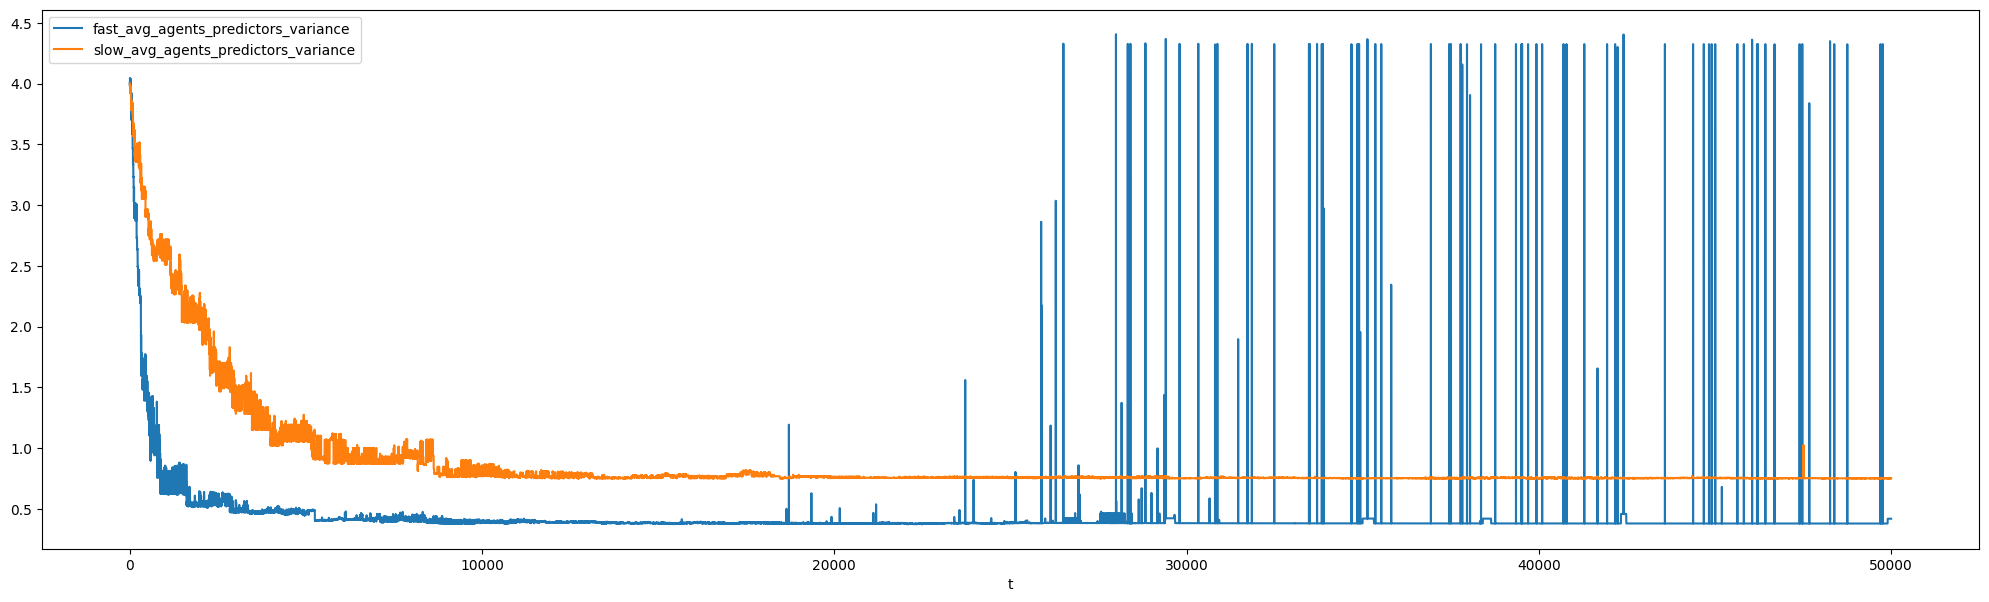

In [16]:
#avg_agents_predictors_variance
ax = fast.avg_agents_predictor_used_variance.plot(figsize=(25,7), label='fast_avg_agents_predictors_variance')
ax = slow.avg_agents_predictor_used_variance.plot(figsize=(25,7), label='slow_avg_agents_predictors_variance')
ax.legend()
#ax.figure.savefig('decreasing_loss.png')

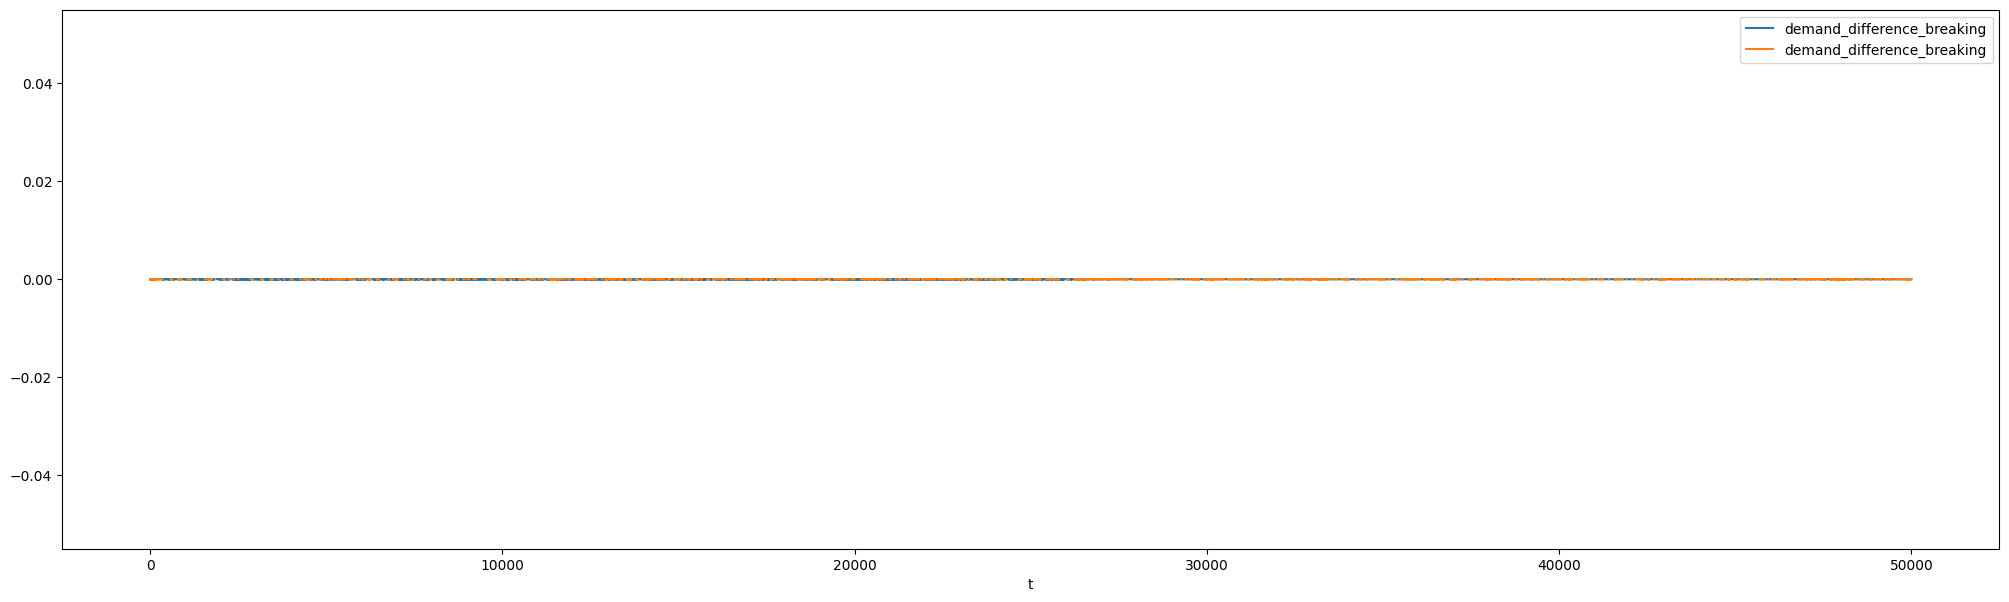

In [29]:
#demand_difference_breaking
ax = fast.demand_difference_breaking.plot(figsize=(25,7), label='demand_difference_breaking')
ax = slow.demand_difference_breaking.plot(figsize=(25,7), label='demand_difference_breaking')
ax.legend()

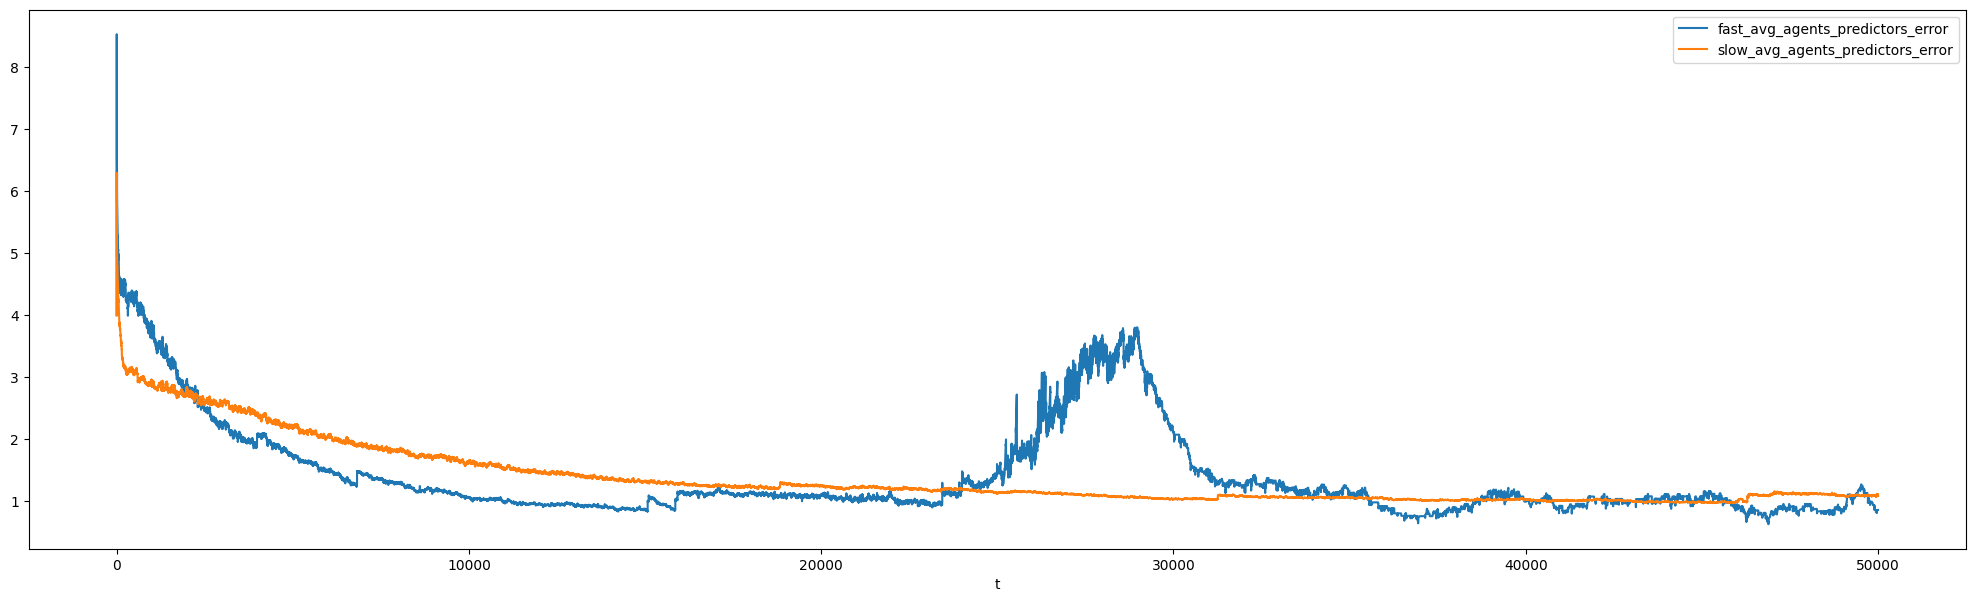

In [17]:
#avg_agents_predictors_error
ax = fast.avg_agents_predictors_error.plot(figsize=(25,7), label='fast_avg_agents_predictors_error')
ax = slow.avg_agents_predictors_error.plot(figsize=(25,7), label='slow_avg_agents_predictors_error')
#ax = fast.sum_agents_predictors_variance.plot(figsize=(25,7), label='fast_sum_agents_predictors_variance')
#ax = slow.sum_agents_predictors_variance.plot(figsize=(25,7), label='slow_sum_agents_predictors_variance')
ax.legend()
#ax.figure.savefig('decreasing_loss.png')

In [27]:
start, end = 12000, 15000

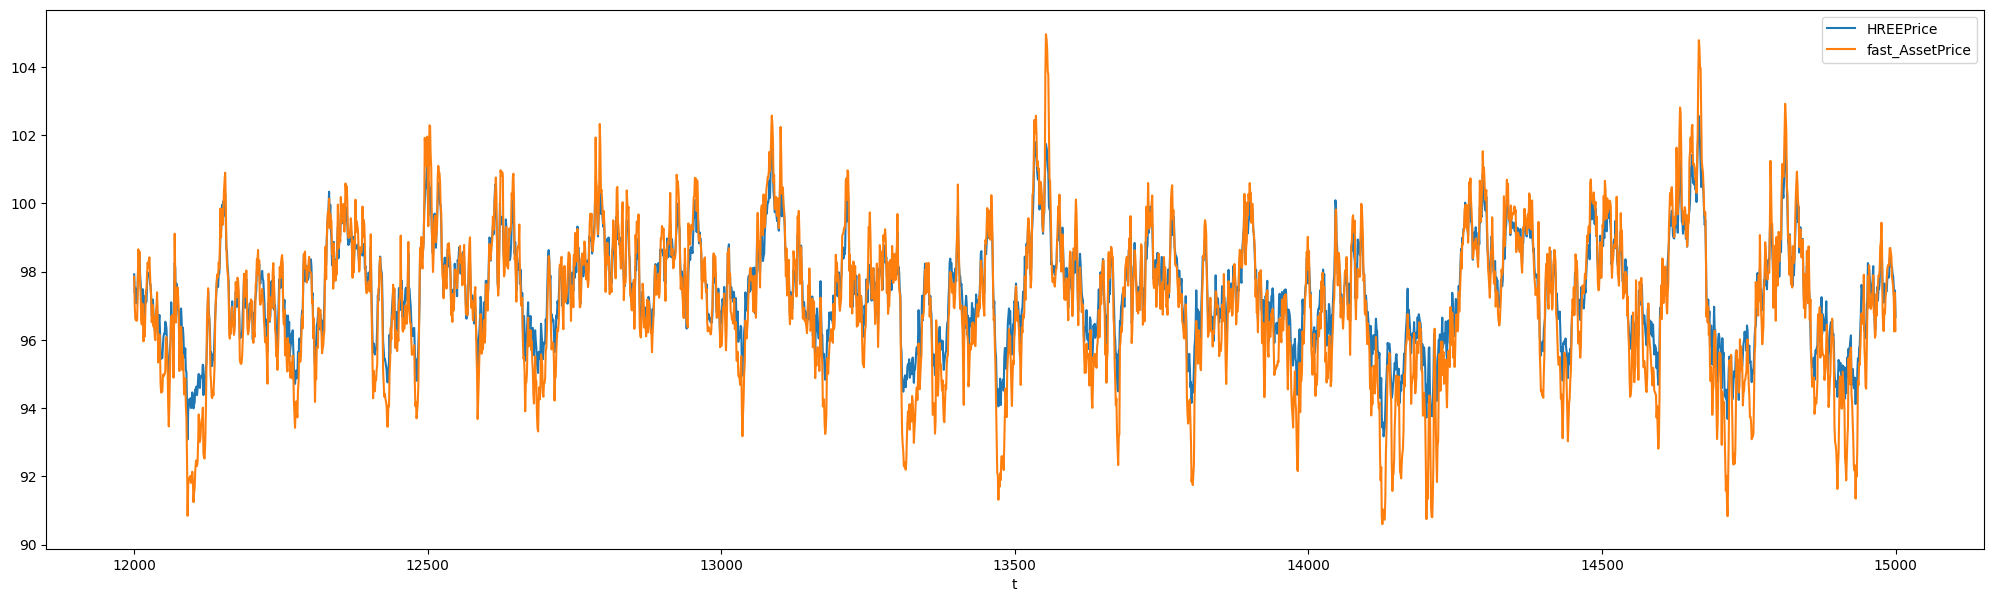

In [28]:
#fig1 - new
ax = fast.loc[start:end, 'HREEPrice'].plot(figsize=(25,7), label='HREEPrice')
#ax = fast.loc[start:end, 'HREEPrice'].plot(figsize=(25,7), label='fast_HREEPrice')
#ax = slow.loc[start:end, 'HREEPrice'].plot(figsize=(25,7), label='slow_HREEPrice')
#ax = slow.loc[start:end, 'AssetPrice'].plot(figsize=(25,7), label='slow_AssetPrice')
ax = fast.loc[start:end, 'AssetPrice'].plot(figsize=(25,7), label='fast_AssetPrice')
ax.legend()